In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import Imputer
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Predicting Building Electric Energy Consumption Based on Building Characteristics:  CBECS Dataset
#### By Noreen Saeed & Chaoyi Chen

For our project we want to analyze energy consumption in commercial buildings.  The problem is an important one because energy prediction helps utility companies in their decision making process to control demand and supply of electricity in the grid.  It also helps in planning for future expansion, and extending the capacity of the electric supply.  Another important aspect of energy analysis is that some building features which lead to increased energy consumption can be identified. Then utility companies can target those buildings by offering incentives to owners for taking steps towards energy efficiency.  For example discounts for adding more insulation to building envelope, or upgraded energy efficient heating equipment etc.

We identified a dataset on the US Energy Information and Administration website called the CBECS Survey Data.  CBECS stands for "Commercial Buildings Energy Consumption Survey".  We are using the survey for data related to the year 2012.  It is a huge data set with 1121 features and 6721 building examples.  For each building example, statistics about the building characteristics like size of building in square feet, shape of building, year of construction etc. are given.  Also given are statsitics about its energy consumption, the type of fuel the building might be using, and associated mechanical equipment for the heating and cooling of the building.  The dataset does not contain information of the city the building is located in because of data privacy concerns of the users.  A broad category of regions is given which identifies a general climatic zone.  This is what the raw CSV file looks like:  <img src="https://i.imgur.com/ZGg7MF9.gif" width=60%>

## Questions to Be Addressed in This Study:

1.  Can annual energy consumption be predicted from building features?  What would be the accuracy of such a prediction?
2.  Which building features contribute to the most energy confsumption or efficiency?
3.  How can raw data be cleaned to produce more efficient results?  What factors contribute to a better prediction?
4.  How do buildings in different climatic region perform with respect to energy consumption?

# PART I:  IMPORTING, CLEANING AND IMPUTING MISSING VALUES

##  Loading and Cleaning the Data.  
To begin our data analysis, we are loading two data files.  The first file contains data of each building's energy use and characteristics.  The list of features given in the data set is so extensive, that there is a second file, which gives an explanation of each characteristic.  So this second file provides the order in which each buildng feature occurs in the data set, the abbreviation used, whether the feature is quantitative, or categorical and the unit of measurement.

The data also has to be cleaned before it can be used.  First we removed columns which deal with all sorts of energy consumption, and added them to a new data frame for use as our labels.  We removed any rows for which the label was missing.  We then dropped columns for which there was too much missing data.  Any column with more than 5% missing values was removed.  We also manually selected some columns to be dropped, which deal with data like building weights, or information as to whether the given values were imputed or reported.  We also dropped all columns which gave any hints about energy consumption, using different fuels etc.

The following two functions load and clean the data.  The first function returns the building features along with labels containing energy consumption info.  The second function returns the codebook which can be used to interpret what each feature represents.

In [2]:
#function adapted to load data from the cbecs 2012 survey data file 

def loadCleanData(filename, ratio, cat, verbose = True):
    """args:  filename:  CBECS data file name, codeBk: filename of codebook with explanation of features
            ratio: columns to discard whose number of missing values is equal to or exceeds (1-ratio)
            cat: additional column indices which may have been  manually selected to be removed.
            bucket:  any additional parameters to use while cleaning data.  False implies none are passed in.
    returns:  dataframe of cleaned data, dataframe of cleaned labels, codebook containing explanation of features"""
    #load the data with features
    df = pd.read_csv(filename)
    if verbose: print('Size of data before cleaing:' , df.shape)
    s = [a for a in df.dtypes if a.name !='int64' and a.name != 'float64'] #Check that all columns are of type ints or floats
    assert s == []
    #drop all rows for which predicted energy consumption is not available
    df.dropna(subset=['ELCNS','ELHTBTU','ELCLBTU','ELVNBTU'], axis=0, inplace=True) #remove all rows where predicted values are NAN
    #Remove outliers where total energy consumption is too much or too less
    df = df[df['ELCNS'] > 1200] 
    df = df[df['ELCNS'] < 4.23e7]
    df = df[df['ELVNBTU'] < .4e8]
    df = df[df['ELCLBTU'] < .6e8]
    df = df[df['ELHTBTU'] < .6e8]
    df.index =  pd.RangeIndex(len(df))  #reindex the dataframe.
    # create df with the labels.  ytotal is Annual electricity consumption (kWh)
    d = {'ytotal' : df['ELCNS'], 'yheat' : df['ELHTBTU'], 'ycool' : df['ELCLBTU'], 'yvent' : df['ELVNBTU']   }
    labels = pd.DataFrame(data=d)
    labels = labels[['ytotal', 'yheat', 'ycool', 'yvent']]
    #remove all useless columns, or ones with target values
    colsToDrop = list(range(445,1118))   #Columns that contain weights or describe whether data was imputed or reported
    colsToDrop.remove(1048)
    colsToDrop.remove(1049)
    #remove addition columns related to categorical data
    colsToDrop.extend(cat)
    colsToDrop = list(set(colsToDrop))
    df = df.drop(df.columns[colsToDrop],axis = 1) 
    #remove columns where 5% (ratio) or more of the data is missing
    df = df.dropna(thresh = np.int(len(df)*ratio) , axis=1)    
    if verbose: print('Size of data after cleaing:' , df.shape)
    return df , labels
    

The following function loads the list of column names, along with explanations of what the columns mean.  For going through the dictionary would reveal that 'OCCUPYP' means percent occupancy, and the data ranges from 0-100.

In [3]:
#creates a dictionary of column name and description
def getCodeBook(codeBk):
    """args:  path +filename of file containing feature names and explanation
    returns:  codeBook: dataframe of column names of features and explanation of what each represents
              codeDict:  dictionay of column names and explanations"""
    codeBook = pd.read_csv(codeBk, usecols=[0,1,5,6], index_col='Variable\nname')
    codeDict = zip(codeBook.index, codeBook['Label'])
    codeDict = {key:value for key,value in codeDict }  
    return codeBook, codeDict

Some columns contain duplicate information, and the following function identifies some of them.  For example, a column containing square foot area of building would be followed by square foot category, which just transforms the area of building into categorical output.  Indices of these columns are collected so that they can be removed from the training and test data.

In [4]:
def getCategory(codeBk):
    """args:  path +filename of file containing feature names and explanation
    returns:  indicies of columns which contain data with divided into categories  """
    df = pd.read_csv(filePath+codeFile, index_col='File order')
    a = df.loc[df['Label'].str.contains('category')].index
    a = a.astype(np.int)
    return a - 1  #subtract 1 because the csv file's index begins at 1 instead of zero

##  Impute missing values
Since removing all rows with missing values will result in an empty data set, we decided to impute values for the columns where less than 5% of the values were missing.  For this we are using the Imputer function provided by the sklearn library, and substituting the most frequently occuring value for the missing values.

In [5]:
#related library:  from sklearn.preprocessing import Imputer
def imputeMissing(df):
    """args:  df:  dataframe with missing values. returns:  dataframe with imputed values"""
    imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=1)
    imp.fit(df)
    df = pd.DataFrame(data=imp.transform(df) , columns=df.columns)
    return df

## Master Function to Load and Clean the Data
So after fully cleaning the data, and imputing missing values, we ended up having a dataset of 6,454 building samples, with 97 features.  Here's how we are loading the data.

In [6]:
def getCleanDataFeatures(filename, codeBk, ratio=.95,divide=.5, verbose=True):
    """args:  filename: path and file of survey file, 
            codeBook: file with codes related to the survey
            k:  number of features to select in select k best algorithm
            ratio:  columns to discard whose percent number of missing values is equal to or exceeds (1-ratio)
    returns: training data, test data, and best features as pandas data frames."""
    #load codes related to features of data
    codeBook, codeDict = getCodeBook(codeBk)
    colInd = getCategory(codeBk)
    #load the data file, and clean it
    df, labels = loadCleanData(filename, ratio,colInd, verbose)
    #impute missing values
    if verbose:
        print('\n')
        print('total number of data points:', df.size)
        print('total number of missing values before imputing:' ,sum(df.isnull().sum().tolist()))
    df = imputeMissing(df)
    if verbose: print('total number of missing values after imputing:' ,sum(df.isnull().sum().tolist()))
    return df,labels,codeBook
 

In [7]:
filePath = 'N:\\15-688\\HWFinalProject\\'
dataFile = '2012_public_use_data_aug2016.csv'
codeFile = '2012microdata_codebook.csv'

df, labels, codeBook = getCleanDataFeatures(filePath+dataFile,filePath+codeFile)

Size of data before cleaing: (6720, 1119)
Size of data after cleaing: (6454, 97)


total number of data points: 626038
total number of missing values before imputing: 4949
total number of missing values after imputing: 0


In [8]:
labels.head()[:5]

,ytotal,yheat,ycool,yvent
0,6081.0,5212.0,646.0,371.0
1,1581997.0,135096.0,765271.0,1356496.0
2,11399.0,0.0,0.0,0.0
3,10932350.0,1643887.0,1709273.0,8981761.0
4,447453.0,0.0,21305.0,532929.0


# PART II:  VISUALIZING AND ANALYSING DATA
Once we loaded the data, we tried to visualize what the data looked like, and plotted a histogram for all four of data of energy consumption for heating, cooling, ventilation and total energy consumption a visual inspection revealed some outliers. We cleaned the data, and removed these outliers, and found that this simple task improved our regression scores considerably.

In [9]:
def histogramsData(data):
    labels = data.columns
    n = len(labels)
    plt.figure(figsize=(20,5))
    for i in range(n):
        plt.subplot(np.ceil(n/4),4,i+1)
        plt.hist(data[labels[i]], bins = 30)
        plt.yscale('symlog')
        plt.xlabel(labels[i])
        plt.ylabel('No. of buildings')
        plt.grid(True)
    plt.show()
    
histogramsData(labels)


### DATA BEFORE REMOVING OUTLIERS
![Image](https://i.imgur.com/KSMdxGv.jpg)


### DATA AFTER REMOVING OUTLIERS
![Image](https://i.imgur.com/EHa6mOR.jpg)


## Divide the Data into Training and Validation Set
Next the data has to be divided into a test set and a validation set.  We randomly assigned 1/2 of the buildings to the test set and 1/2 of the examples to the training set.

In [10]:
def divideData(df,label, ratio, seeds=7): 
    """args:    df: dataframe to divide, 
                ratio: ratio in which to divide it, seeds: random seed for consistent result
    returns:  training data, and test data"""
    np.random.seed(seeds)
    P = np.arange(df.shape[0])
    np.random.shuffle(P)
    size = int(len(df) *  ratio)
    trainX = df.iloc[P[:size] ]
    testX = df.iloc[P[size:]]
    trainY = label.iloc[P[:size] ]
    testY = label.iloc[P[size:] ]
    return trainX, trainY, testX, testY

## Find Best Performing Features
We used k-means algorithm to find out the best performing features.  This returned the best performing features in the data, and assigned a score based on the contribution of each feature.  It also gives a p-value which shows how significant each feature's contribution is.  After obtaining the best features, we attached them to our dictionary, to get a better idea about what type of data each feature represents.

In [11]:
#related library:  from sklearn.feature_selection import SelectKBest
def showBest(X,y, coef, codeBook):
    """args:    names:  list of column names
                codeBook:  dataframe explaining what each column label represents
    returns:  dataframe with scores and explanation of what each column represents"""
    viewScores = pd.DataFrame(index= X.columns, data= coef, columns=['Weights'])
    np.seterr(divide='ignore', invalid='ignore')
    sel = SelectKBest(f_regression)
    sel.fit(X, y)
    #x = sel.transform(trainX)
    viewScores['Scores'] = sel.scores_
    viewScores['p-values'] = sel.pvalues_
    viewScores['Labels'] = codeBook['Label']
    viewScores['Format'] = codeBook['Values/Format codes']
    viewScores['Format'].replace(to_replace="\n", value=' ', inplace=True)
    return viewScores

#### RESULTS & ANALYSIS:  K-Best Features
Once we had the results from the k-best features (using only test data) we sorted them in descending order.  This gave us a good sense of what building features, management practices contribute the most to energy consumption.  Here's what the results look like:
![k-Best](https://i.imgur.com/1xaMNmv.jpg)
Some of the results are fairly what we expected.  For example the strongest predictor is the square footage, which just implies that bigger buildings will consume more energy and vice versa.  However, this exercise also gave us a good sense of other important energy hoggers like whether the building is open 24 hours a day or not, how using electricity for cooking has a major impact on energy consumption.  Number of laptops and other equipment also seems to have a huge energy impact along with type of lighting eg halogen bulb usage etc.  There were also some interesting finds like how having an atrium or skylight can also effect consumption.

We also noticed how categorical data with responses of just a 'yes' or 'no' are as important at predicting energy consumption as continuous variables like number of employees etc.

## Regression Using Four Different Algorithms, with Cross Validation and Grid Search
After dividing the data into training and test sets, we used grid search with cross validation to fine tune our hyper-parameters.  We used sk-learn's built in algorithm to narrow down our hyper parameter search.  However, we found that using grid search was time consuming and the computer often got stuck.  To overcome this annoyance, we had to remove this from our pipeline, and manually did a grid search for each type of algorithm and recorded it separately to be used with the appropriate algorithm.

In [12]:
from sklearn.model_selection import GridSearchCV

def bestParams(estimator, params, x, y):
    clff = GridSearchCV(GradientBoostingRegressor(), params, cv = 5, scoring = 'r2' )
    clff.fit(x, y)
    return clff.best_params_

We tried to run our code with different algorithms to see which one performed the best with our data.  We tested out linear regression, kernel ridge regression, orthogonal matching pursuit and the gradient boosting regressor.  We created a single function which can take in the estimator, the parameters we found earlier through grid search, and the data comprising of test and train sets and out put r2 scores for regression.

In [13]:
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.ensemble import GradientBoostingRegressor

def regress(estimator, params, data):
    trainX, trainY, testX, testY = data[0], data[1], data[2], data[3]
    regr = estimator()
    regr.set_params(**params)
    regr.fit(trainX, trainY)
    yHatTest = regr.predict(testX)
    testScore = regr.score(testX, testY)
    trainScore = regr.score(trainX, trainY)
    return trainScore, testScore, regr.predict(trainX), yHatTest

In [14]:
#following function taken from 15-388 HW-3 on Linear Regression
def getMSE(LR, X, y, X_v, y_v):
    predTr = LR.predict(X)
    mseTrain = (np.square(predTr - y  )).mean()
    mseTrainMean = (np.square( y.values.mean() - y  )).mean()
    predVal = LR.predict(X_v)
    mseValid = (np.square(predVal - y_v.values )).mean()
    mseValidMean = (np.square(y.values.mean() - y_v.values  )).mean()
    return mseTrain,mseValid, mseTrainMean,  mseValidMean

## Visualizing the Results
We also dedicated some code just to output some graphs for easy visualization of results.

In [15]:
def makeSimpleBar(data,title,names):
    y_pos = np.arange(len(names))
    plt.bar(y_pos, data, align='center', alpha=.7, color='orange',edgecolor='black')
    plt.xticks(y_pos, names,rotation='vertical')
    plt.title(title)
    return plt    

In [16]:
def makeBarChart(names, train, test):
    pos = list(range(len(names))) 
    width = 0.25 
    colors = [['c','teal'],['sienna','sandybrown'],['#EE3224','#F78F1E'] ]
    fig, ax = plt.subplots(figsize=(10,5))
    plt.bar([p + width*0 for p in pos],train,color='#EE3224', width=width, alpha=.8)
    plt.bar([p + width*1 for p in pos],test,color='#F78F1E', width=width, alpha=.8)
    ax.set_ylabel('Score')
    ax.set_title('Regression Scores')
    ax.title.set_fontsize(16)
    ax.set_xticks([p + .5 * width for p in pos])
    ax.set_xticklabels(names)
    ax.xaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontsize(12)
    plt.legend(['training score', 'test score'], loc='upper right')
    plt.grid()
    return plt


In [17]:
def makeScatters( ytruTrain,yhatTrain,ytruTest,yhatTest):
    fig, ax = plt.subplots(figsize=(7,7))
    s = 121
    ax.scatter(ytruTrain, yhatTrain, color='b', s=s/3, alpha=.4, label='Training Set')
    ax.scatter(ytruTest, yhatTest, color='r', s=s/2, alpha=.4, label='Test Set')
    ax.set_ylabel('Predicted Energy Consumption')
    ax.set_xlabel('True Energy Consumption')
    ax.set_title('True vs Predicted Energy Consumption')
    ax.title.set_fontsize(16)
    ax.xaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontsize(12)
    plt.ylim(-4e6, 5e7)
    plt.xlim(-4e6, 5e7)
    x = np.linspace(0,5e7,4)
    ax.legend()
    return plt

## Put Everything Together to Form Analysis

### Analyze Total Energy Used
The following set of functions predict the total energy consumption of buildings based on building features.  This part of the code explores different algorithms, and related accuracy levels achieved.

In [18]:
def analyzeTotal(df, labels, codeBook):
    trainX, trainY, testX, testY = divideData(df,labels,.5)
    data = trainX, trainY['ytotal'], testX, testY['ytotal']
    estimators = [linear_model.LinearRegression, KernelRidge, GradientBoostingRegressor, OrthogonalMatchingPursuit]
    parameters = [{},{'alpha': 10, 'gamma' : .001, 'kernel' : 'linear'},{'max_depth': 2, 'n_estimators': 100},{'n_nonzero_coefs':20}]
    names = ['Linear Regression', 'Kernel Ridge Regression','Gradient Boosting','Orthogonal Matching Pursuit'  ]
    train = []
    test = []
    yHatTrain = []
    yHatTest = []
    for i in range(len(estimators)):
        tr, te, yHatTr, yHatTe = regress(estimators[i],parameters[i],data)
        train.append(tr)
        test.append(te)
        yHatTrain.append(yHatTr)
        yHatTest.append(yHatTe)
    best = test.index(max(test))
    print('Best Regressor: ', names[best], 'With test score of: ', test[best] )
    plot = makeBarChart(names, train, test)
    scat = makeScatters(trainY['ytotal'],yHatTrain[2],testY['ytotal'],yHatTest[2]  )
    p = linear_model.LinearRegression()
    p.fit(trainX, trainY['ytotal'])
    scoresDf = showBest(trainX,trainY['ytotal'], p.coef_, codeBook)
    mses = getMSE(p, trainX, trainY['ytotal'], testX, testY['ytotal'])
    return plot, yHatTest, scat, scoresDf, mses

In [22]:
plot, yHatTest, scat, scoresDf, mses = analyzeTotal(df, labels, codeBook)
names = ['mse on training','mse on validation','mse Mean on training', 'mse Mean on validation']
bar = makeSimpleBar(mses,'Mean Squared Errors',names )
plot.show()
scat.show()
bar.show()

Best Regressor:  Gradient Boosting With test score of:  0.840630811551


#### Result and Analysis: Gradient Boosting Best Algorithm for Data with r2 Score of .84
After fine tuning hyper parameters using grid search, we compared results for all the four regression algorithms and found that gradient boosting performs the best on our data set.  At first we did not get good results, but we kept tuning our input features, and saw that removing outliers was the easiest way to increase scores.  Here's what the regression scores of all four algorithms look like before and after removing outliers.

![Regression Scores](https://i.imgur.com/dBuyhOx.jpg)

We found a fairly good correlation between building features and energy consumption.  __Our algorithm can account for 84% of the variation in the test data__.  Our scatter plot indicates how the predictions on the training data are a little bit more accurate than the test data.  This is consistant with the bar chart showing a better accuracy for training data.  This implies that the gradient boosting algorithm has a tendency to over fit the data.  We also see how removing outliers from our training data helped fine tune our predictions with a sharper correlation seen in the scatter plot.

![Scatter Plots](https://i.imgur.com/10ICnLx.jpg)

We also output the mean squared errors, and made comparisons with the baseline of mse on predicting the mean on the training and the test set.  We got good results in all cases.  Here's how our predicted label of total energy consumption compares with the true labels. Here's what the mean squared errors look like.
![MSE](https://i.imgur.com/LO0u3zz.jpg)


In [23]:
scoresDf.sort_values(by='Scores', ascending=False)[:3]

,Weights,Scores,p-values,Labels,Format
SQFT,13.492576,7976.074215,0.0,Square footage,"1,001 - 1,500,000"
NWKER,1123.923898,3388.703456,0.0,Number of employees,"0 - 6,500"
PCTERMN,1399.288203,2463.311775,0.0,Number of computers,"0 - 4,195\nMissing = Not applicable"


### Analyze Energy Consumption of Heating, Cooling, Ventilation and Total Energy Consumption
The next part of the code analyzes different components of electrical energy consumption

In [24]:
def analyzeAll(df, labels):
    cols = labels.columns
    trainX, trainY, testX, testY = divideData(df,labels,.5)
    params = {'max_depth': 3, 'n_estimators': 75}
    regressors = []
    train = []
    test = []
    ycol = trainY.columns
    for i in range(len(cols)):
        tr, te, yHatTr, yHatTe = regress(GradientBoostingRegressor,params,(trainX, trainY[ycol[i]], testX, testY[ycol[i]]))
        train.append(tr)
        test.append(te)
    bar = makeBarChart(ycol, train, test)
    clf = GradientBoostingRegressor()
    clf.fit(trainX, trainY['ytotal'])
    return bar
    

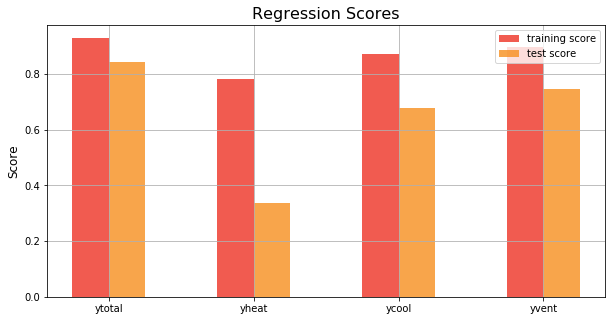

In [27]:
a = analyzeAll(df, labels)
a.show()

We were a little suprised to see that we were unable to predict good scores for the heating.  While our estimate of total energy consumption was fairly high, we saw that the component energy consumption was not doing so well.  We traced the source of the error to how there is very less energy being used for heating.  It means that heating in many buildings is being done using gas or some other fuel instead of electricity.  __We see from the following graph that the values for which MORE data was available, had a better chance of a higher accuracy.__
![energy](https://i.imgur.com/0h389yj.jpg)

### Effect of Size of Training Data on Score of Test Data
The following code attempts to find out how the size of training data would effect scores.

In [31]:
import warnings
warnings.filterwarnings("ignore")

def get_err_samples(clf, x_train, y_train, x_cv, y_cv, n_samples):
    clf.fit(x_train[:n_samples], y_train[:n_samples])
    return np.array([clf.score(x_train[:n_samples], y_train[:n_samples]), clf.score(x_cv, y_cv)])

def sampleSizeEffect(clf, x_train,y_train, x_cv, y_cv ):
    n_samples = [int(x) for x in np.linspace(20, x_train.shape[0], 15)]
    errors = np.array([get_err_samples(clf, x_train, y_train, x_cv, y_cv, n) for n in n_samples])
    fig, ax = plt.subplots()
    ax.plot(n_samples, errors[:,0])
    ax.plot(n_samples, errors[:,1])
    ax.set(xlabel='Number of Samples', ylabel='Test Score',
       title='Effect of Sample Size on Test Score')
    ax.legend("Training", "Validation")
    ax.grid()
    return plt

def analyzeSampSize(df, labels):
    cols = labels.columns
    trainX, trainY, testX, testY = divideData(df,labels,.5)
    params = {'max_depth': 3, 'n_estimators': 75}
    regressors = []
    train = []
    test = []
    ycol = trainY.columns
    for i in range(len(cols)):
        tr, te, yHatTr, yHatTe = regress(GradientBoostingRegressor,params,(trainX, trainY[ycol[i]], testX, testY[ycol[i]]))
        train.append(tr)
        test.append(te)
    clf = GradientBoostingRegressor()
    clf.fit(trainX, trainY['ytotal'])
    return sampleSizeEffect(clf,trainX, trainY['ytotal'], testX, testY['ytotal'])  

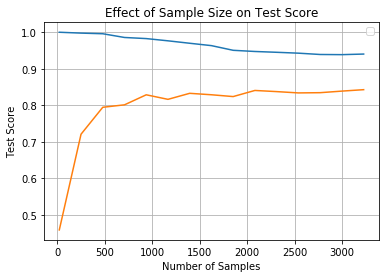

In [32]:
b = analyzeSampSize(df, labels)
b.show()

We also studied the effect of having a large or small sample size for training our data.  We plotted the training and test accuracy, which showed that an increased sample size decreased the gap between the test and training errors.  This means that a bigger sample size is likely to decrease over-fitting of the data

### Statistics for Different Climate Regions

For deeper understanding and further analysis of our data, buildings are divided by using the feature "Building America climate region" provided.

There are five different catagories for this feature, which are:
* '1' = 'Very cold/Cold'
* '2 '= 'Mixed-humid'
* '3' = 'Hot-dry/Mixed-dry/Hot-humid'
* '5' = 'Marine'
* '7' = 'Withheld to protect confidentiality'

#### 1. Distribution of regions.

A barchar (actual implementation is done by using the histogram functionality with specified ranges of bins) is create for the amount of buildings in each climate region. Meanings of x-axis is explained in above cell.

Interpretation: Sufficent amount of smaples are in the climate region "1", "2", "3". There is a relative lack of sample for climate "5" and "7".

In [ ]:
plt.hist(df['PUBCLIM'], bins=np.arange(0,8,0.5));

#### 2. Divide and analysis
The `divide_climate` helper function is used to divide the data into differnet climate regions, then gradient boosting regressor is used for training and learning. (with hyperparameter search conducted as well)

In [34]:
def divide_climate(df, label):
    """args:    df:  dataframe of the whole sample (after cleaning and imputing)
             label:  dataframe labels (results, that are the differnet types of consumptions)
    returns:  A list of lists. Inner list is in the format: [x_train, y_train, x_test, y_test]"""
    
    result_list = []
    climate_set = sorted(df['PUBCLIM'].unique())
    for climate in climate_set:
        climate_df = df[df['PUBCLIM'] == climate]
        climate_label = label[df['PUBCLIM'] == climate]
        climate_label = climate_label['ytotal']
        x_train, y_train, x_test, y_test = divideData(climate_df, climate_label, 0.7)
        result_list.append([x_train, y_train, x_test, y_test])
    return result_list

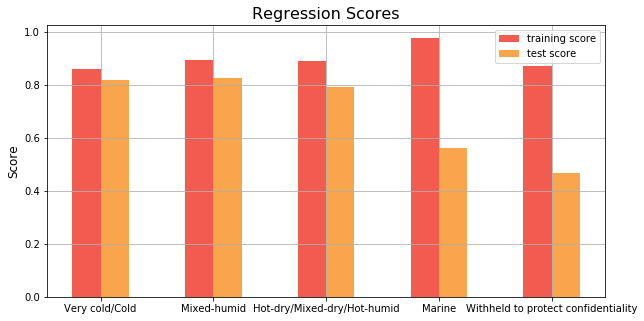

In [35]:
climate_list = divide_climate(df, labels)
train = []
test = []
params = {'max_depth': 2, 'n_estimators': 50}
ycol = ['Very cold/Cold', 'Mixed-humid','Hot-dry/Mixed-dry/Hot-humid','Marine','Withheld to protect confidentiality']
for each_climate in climate_list:
    tr, te, yHatTr, yHatTe = regress(GradientBoostingRegressor,params,(each_climate[0], each_climate[1],
                                                                       each_climate[2], each_climate[3]))
    train.append(tr)
    test.append(te)
bar = makeBarChart(ycol, train, test)
bar.show()

The result of training is generally good for climates with enough sample, while not so good for the other. There is a likely a over fit for catagory "5" (Marine) from the high training score and low test score. Catagory for buidlings that do not have region information scores the loweset, due to the smallest sample size with mix of inherent differences in samples.
![Consumption](https://i.imgur.com/gSvyPoG.jpg)

__We also see that the buildings which consume the most energy do not have any label w.r.t the region or climate category attached to them.  Having this information would have improved our results.__

A consice scatter plot is shown below for the relation between samplw size and training score.

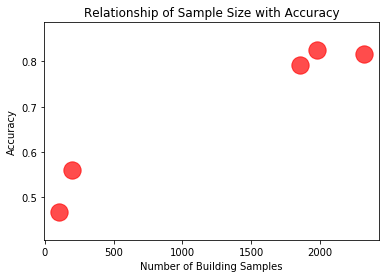

In [36]:
climate_set = sorted(df['PUBCLIM'].unique())
climate_sample_size = []
for i in climate_set:
    climate_sample_size.append(df[df['PUBCLIM'] == i].shape[0])


plt.scatter(climate_sample_size, test, color='r',s = 300, alpha=.7, label='Training Set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Building Samples')
plt.title('Relationship of Sample Size with Accuracy')
plt.show()

### Direction for Future Work:

1  It would be interesting to see if energy consumption per square foot can be inferred from this data.  This would give a more clear picture of what building features contribute most to energy efficiency.

2  CBECS does not contain city data, so weather data could not be used.  Future work to relate more to weather data

3  Study of the use of other fuels like gas, oil, coal etc. would also be a good avenue.
